# Study Phase Plot ###

2024-10-08 14:03:59,287 - INFO - Non-numeric rating values encountered and disregarded: 0
2024-10-08 14:03:59,288 - INFO - Found 5967 drug names with ratings in the database.
2024-10-08 14:04:12,148 - INFO - Data prepared for table:                       Drug  Average Rating  Study Phase I  Study Phase II  \
0   Carboxymethylcellulose            0.00             56              58   
1               Homosalate            0.72              1               0   
2        Phenyl salicylate            0.69              0               0   
3             Hypromellose            0.02             84             121   
4  Polyethylene glycol 400            0.71            103             140   

   Study Phase III  Study Phase IV  Study Phase Undefined  
0               36              49                    101  
1                1               0                      2  
2                0               0                      0  
3               68             110                    233  
4   

Number of non-numeric rating values disregarded: 0


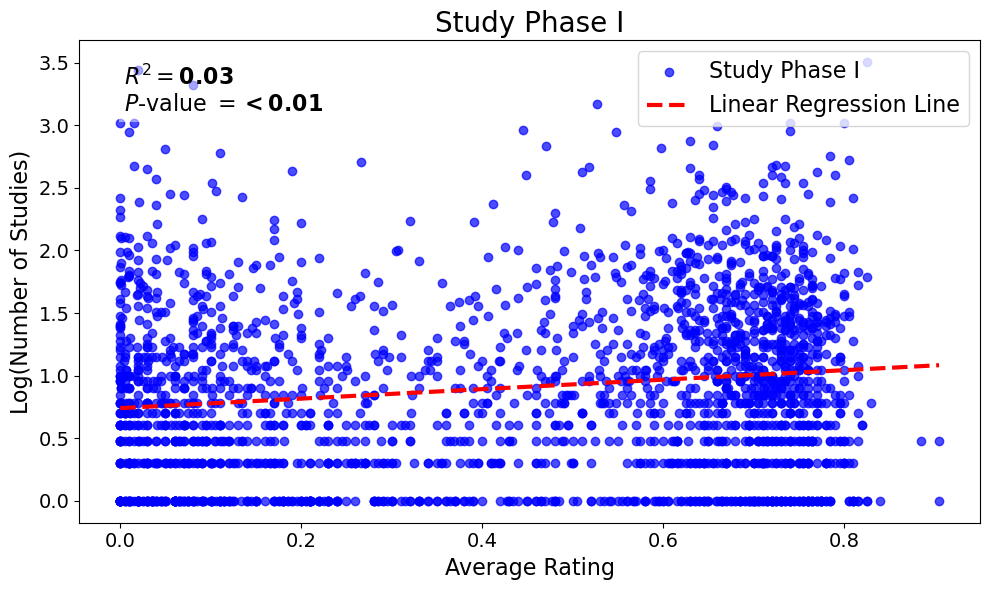

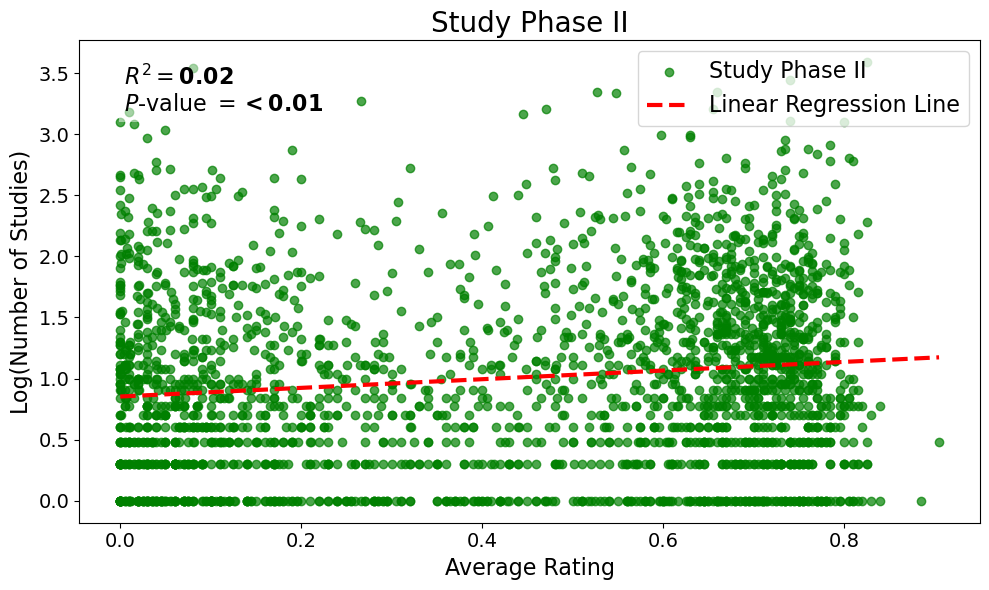

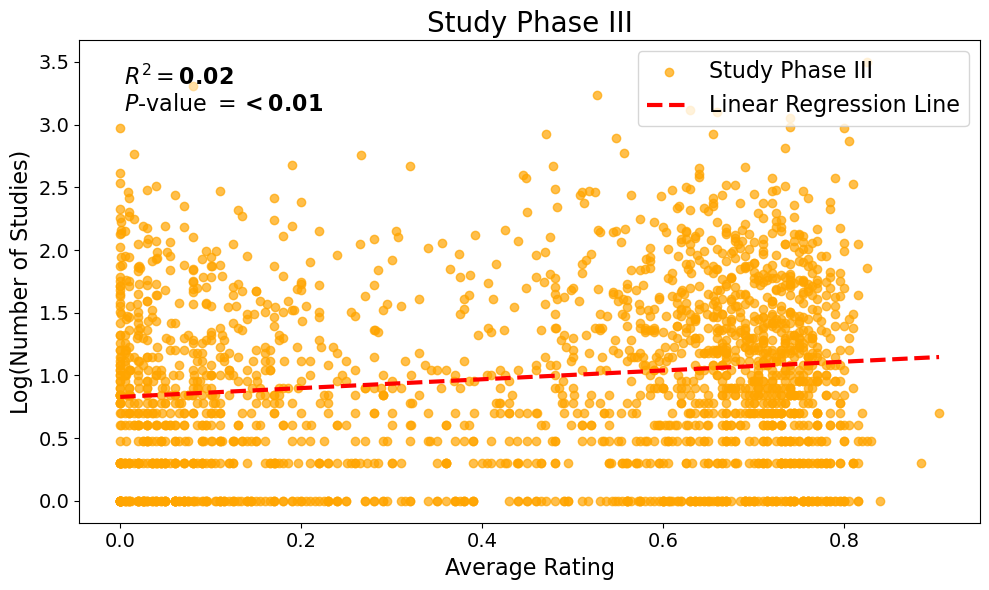

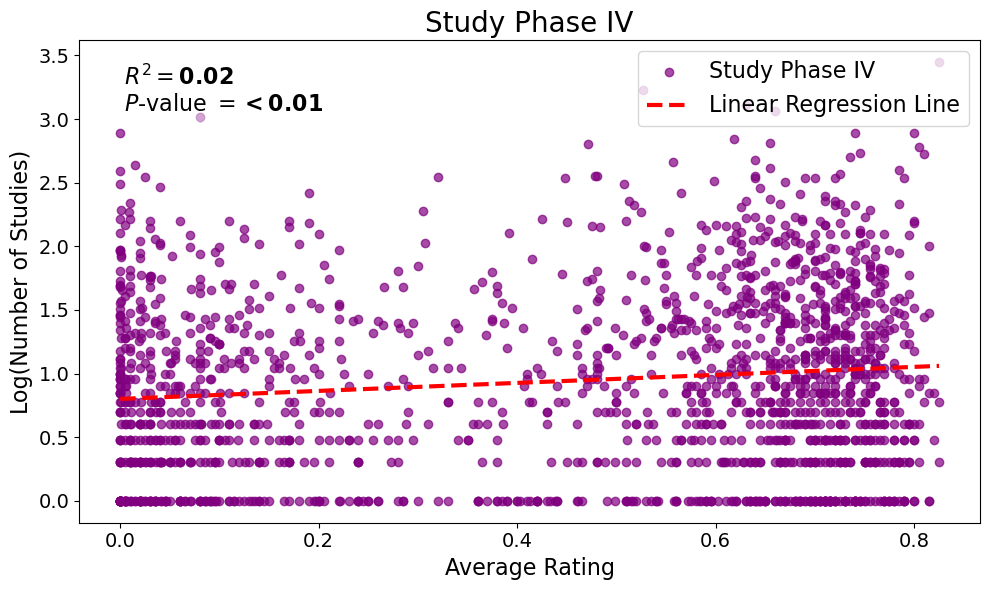

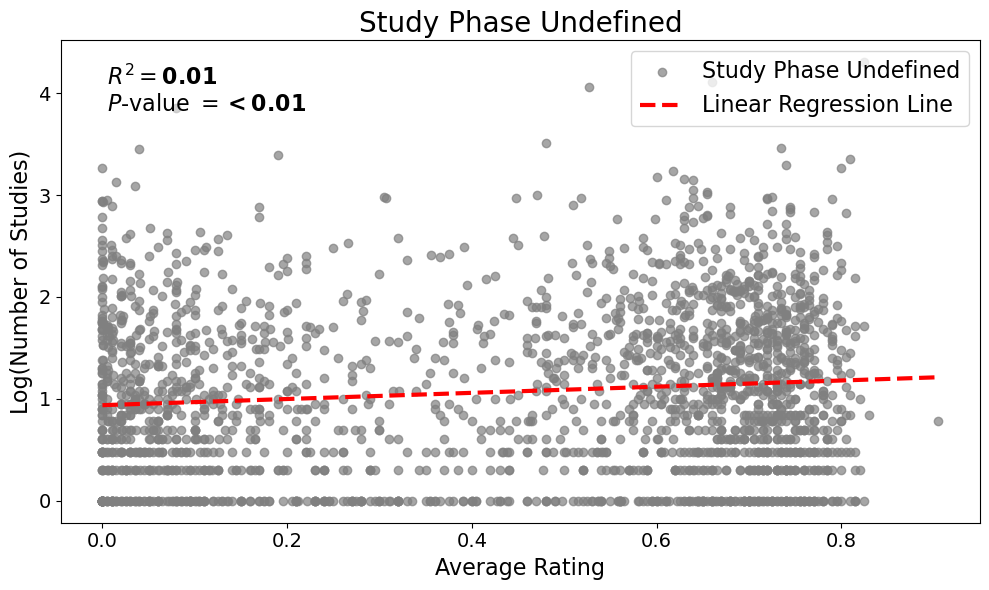

In [2]:
import os
import json
import logging
import re
from neo4j import GraphDatabase
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import linregress

# Load environment variables
load_dotenv()

# Set up logging
log_filename = "multipanel_scatter_plot.log"
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler(log_filename),
                              logging.StreamHandler()])

# Set up a critical level logger
critical_log_filename = "multipanel_scatter_plot_critical.log"
critical_logger = logging.getLogger('critical_logger')
critical_logger.setLevel(logging.CRITICAL)
critical_handler = logging.FileHandler(critical_log_filename)
critical_logger.addHandler(critical_handler)

# Connection details
uri = os.getenv("uri")
username = os.getenv("username")
password = os.getenv("password")

# Path to the directory containing JSON files
directory = "/Users/ricoandreschmitt/Code/GitHub/allmzheimer/clinical_trials_data/clinical_trials_data_1"

# Phase mapping
phase_mapping = {
    "NA": 0,
    "EARLY_PHASE1": 1,
    "PHASE1": 2,
    "PHASE2": 3,
    "PHASE3": 4,
    "PHASE4": 5
}

def get_drug_data_from_neo4j(uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    query = """
    MATCH (n)
    WHERE n.rating_0 IS NOT NULL OR n.rating_1 IS NOT NULL OR n.rating_2 IS NOT NULL OR n.rating_3 IS NOT NULL
    OR n.rating_4 IS NOT NULL OR n.rating_5 IS NOT NULL OR n.rating_6 IS NOT NULL OR n.rating_7 IS NOT NULL
    OR n.rating_8 IS NOT NULL OR n.rating_9 IS NOT NULL
    RETURN n.name AS name, 
           n.rating_0 AS rating_0, n.rating_1 AS rating_1, n.rating_2 AS rating_2, n.rating_3 AS rating_3, 
           n.rating_4 AS rating_4, n.rating_5 AS rating_5, n.rating_6 AS rating_6, n.rating_7 AS rating_7, 
           n.rating_8 AS rating_8, n.rating_9 AS rating_9
    """
    drug_data = []
    non_numeric_count = 0

    with driver.session() as session:
        result = session.run(query)
        for record in result:
            ratings = []
            for i in range(10):
                rating_value = record.get(f"rating_{i}")
                try:
                    ratings.append(float(rating_value))
                except (ValueError, TypeError):
                    if rating_value is not None:
                        non_numeric_count += 1
                    continue
            if ratings:
                average_rating = sum(ratings) / len(ratings)
                drug_data.append({"name": record["name"], "average_rating": average_rating})

    driver.close()
    logging.info(f"Non-numeric rating values encountered and disregarded: {non_numeric_count}")
    return drug_data, non_numeric_count

def count_studies(directory, drug_name):
    sanitized_name = re.sub(r'[^\w\s-]', '', drug_name).strip().replace(' ', '_')
    filename = os.path.join(directory, f"{sanitized_name}.json")
    study_counts = {phase: 0 for phase in phase_mapping.keys()}

    if os.path.exists(filename):
        with open(filename, 'r') as file:
            data = json.load(file)
            for trial in data:
                phases = trial["protocolSection"]["designModule"].get("phases", ["NA"])
                for phase in phases:
                    study_counts[phase] += 1

    return study_counts

def create_table(drug_data):
    table_data = []

    for drug in drug_data:
        study_counts = count_studies(directory, drug["name"])
        table_row = {
            "Drug": drug["name"],
            "Average Rating": drug["average_rating"],
            "Study Phase I": study_counts.get("PHASE1", 0),
            "Study Phase II": study_counts.get("PHASE2", 0),
            "Study Phase III": study_counts.get("PHASE3", 0),
            "Study Phase IV": study_counts.get("PHASE4", 0),
            "Study Phase Undefined": study_counts.get("NA", 0) + study_counts.get("EARLY_PHASE1", 0)
        }
        table_data.append(table_row)

    # Create a DataFrame from the table data
    df = pd.DataFrame(table_data)
    return df

def log_sanity_checks(df, phases):
    for phase in phases:
        phase_data = df[["Drug", "Average Rating", phase]].sort_values(by="Average Rating", ascending=False)
        num_dots = len(phase_data[phase_data[phase] > 0])
        critical_logger.critical(f"{phase}: {num_dots} dots")

        top_3_drugs = phase_data.head(3)
        critical_logger.critical(f"Top 3 drugs in {phase} based on Average Rating:")
        critical_logger.critical("\n" + top_3_drugs.to_string(index=False))



def plot_separate_scatter_plots(df):
    phases = ["Study Phase I", "Study Phase II", "Study Phase III", "Study Phase IV", "Study Phase Undefined"]
    colors = ['blue', 'green', 'orange', 'purple', 'grey']  # Different colors for each phase

    for i, phase in enumerate(phases):
        plt.figure(figsize=(10, 6))
        x = df["Average Rating"]
        y = df[phase].replace(0, np.nan)  # Replace zeros to avoid log(0)
        log_y = np.log10(y)

        # Filter out NaN values from both x and log_y
        valid_idx = ~log_y.isna()
        x_valid = x[valid_idx]
        log_y_valid = log_y[valid_idx]

        plt.scatter(x_valid, log_y_valid, color=colors[i], alpha=0.7, label=f'{phase}')
        
        # Increase font size for the title, labels, and legend
        plt.title(phase, fontsize=20)
        plt.xlabel("Average Rating", fontsize=16)
        plt.ylabel("Log(Number of Studies)", fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        # Linear Regression
        if len(x_valid) > 1:  # Check if there's enough data for regression
            slope, intercept, r_value, p_value, std_err = linregress(x_valid, log_y_valid)
            x_fit = np.linspace(min(x_valid), max(x_valid), 500)
            y_fit = slope * x_fit + intercept

            # Format p-value
            if p_value < 0.01:
                p_value_str = "< 0.01"
            else:
                p_value_str = f"{p_value:.2e}"

            # Include only "Linear Regression Line" in the legend label
            plt.plot(x_fit, y_fit, color='red', linestyle='--', linewidth=3, label='Linear Regression Line')  # Dashed, thicker line

            # Add R² and p-value as text annotations on the plot
            textstr = r'$R^2 = \mathbf{{{}}}$' '\n' r'$P$-value $= \mathbf{{{}}}$'.format(f'{r_value**2:.2f}', p_value_str)
            plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                     fontsize=16, verticalalignment='top',
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        # Adjust legend properties
        plt.legend(fontsize=16, loc='upper right')
        plt.tight_layout()
        plt.show()  # Show each plot one by one




def main():
    drug_data, non_numeric_count = get_drug_data_from_neo4j(uri, username, password)
    logging.info(f"Found {len(drug_data)} drug names with ratings in the database.")

    df = create_table(drug_data)
    logging.info(f"Data prepared for table: {df.head()}")

    # Display the number of non-numeric values disregarded
    print(f"Number of non-numeric rating values disregarded: {non_numeric_count}")

    # Plot the multipanel scatter plot
    plot_separate_scatter_plots(df)

if __name__ == "__main__":
    main()




